In [1]:
# This demo showcases brain-specific registration of computed tomography (CT) to
# magnetic resonance images (MRI) with SynthMorph. Further information is
# available at: https://synthmorph.io.
#
# If you find the demo useful, please cite:
#
#     Anatomy-aware and acquisition-agnostic joint registration with SynthMorph
#     Hoffmann M, Hoopes A, Greve DN, Fischl B*, Dalca AV* (*equal contribution)
#     Imaging Neuroscience, 2, pp 1-33, 2024
#     https://doi.org/10.1162/imag_a_00197
#
# We distribute this notebook under the "2-clause BSD" license:
# https://choosealicense.com/licenses/bsd-2-clause

In [2]:
# Packages from GitHub.
!pip -q install git+https://github.com/adalca/neurite.git@0776a575eadc3d10d6851a4679b7a305f3a31c65
!pip -q install git+https://github.com/freesurfer/surfa.git@ec5ddb193fd1caf22ec654c457b5678f6bd8e460
!pip -q install git+https://github.com/voxelmorph/voxelmorph.git@2cd706189cb5919c6335f34feec672f05203e36b

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done


In [3]:
import numpy as np
import surfa as sf
import matplotlib.pyplot as plt

In [4]:
# Downloads. We use CT data from patient 77654033 in the Patient-Contributed
# Image Repository (https://www.pcir.org/researchers/77654033_19950903.html) and
# unprocessed T1-weighted MRI data from subject Afterthought in Mindboggle-101
# (https://mindboggle.info/).
%%sh
mkdir -p models synthmorph
get() { ( cd "${2:-.}" ; [ -e "$(basename "$1")" ] || curl -O "$1" ; ) }

url=https://raw.githubusercontent.com/freesurfer/freesurfer/9f23ef349976e3b455778f865bceed24d79aa89d
get $url/mri_synthmorph/mri_synthmorph
get $url/mri_synthmorph/synthmorph/registration.py synthmorph
get $url/mri_synthmorph/synthmorph/utils.py synthmorph

get https://surfer.nmr.mgh.harvard.edu/docs/synthmorph/images/ct.nii.gz
get https://surfer.nmr.mgh.harvard.edu/docs/synthmorph/images/t1.nii.gz
get https://surfer.nmr.mgh.harvard.edu/docs/synthmorph/synthmorph.affine.2.h5 models

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 15350  100 15350    0     0  42879      0 --:--:-- --:--:-- --:--:-- 42997
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11569  100 11569    0     0  31413      0 --:--:-- --:--:-- --:--:-- 31352
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2890  100  2890    0     0  11882      0 --:--:-- --:--:-- --:--:-- 11942
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 47.3M  100 47.3M    0     0  27.9M      0  0:00:01  0:00:01 --:--:-- 27.9M
  % Total    % Received % Xferd  Average Speed   Tim

In [5]:
# SynthMorph setup.
%env FREESURFER_HOME=/content
!chmod +x mri_synthmorph
!./mri_synthmorph

env: FREESURFER_HOME=/content
usage: mri_synthmorph [-h] {register,apply} ...


In [6]:
# Helper functions.
def normalize(x):
  x -= x.min()
  return x / x.max()


def show(im, title=None):
  im = np.asarray(im.resize(voxsize=1).reshape((256, 256, 256)).reorient('ILP'))
  fig, axes = plt.subplots(1, 3, figsize=(12, 4))

  slices = im[:, 125, :], im[:, :, 127], im[127, :, :].T
  for im, ax in zip(slices, axes):
    ax.imshow(im, cmap='gray')
    ax.set_axis_off()

  if title:
    axes[1].text(0.50, 1.05, title, ha='center', transform=axes[1].transAxes, size=14)

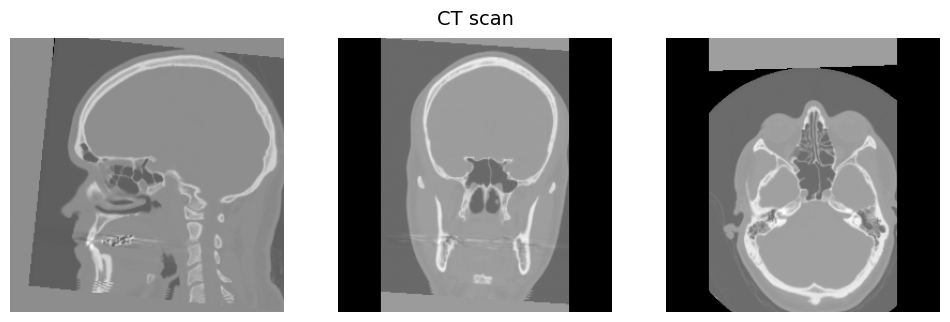

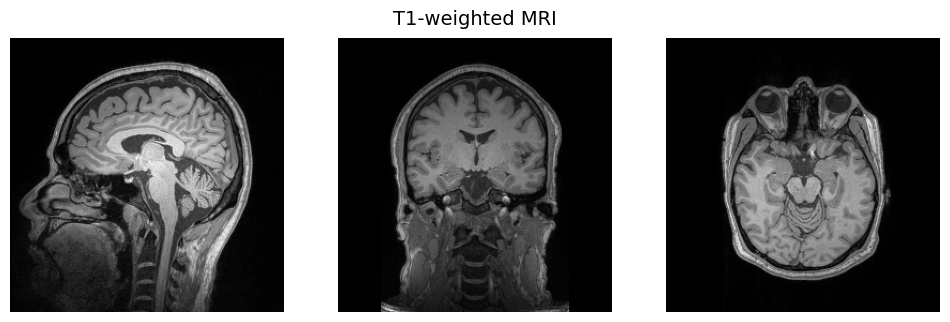

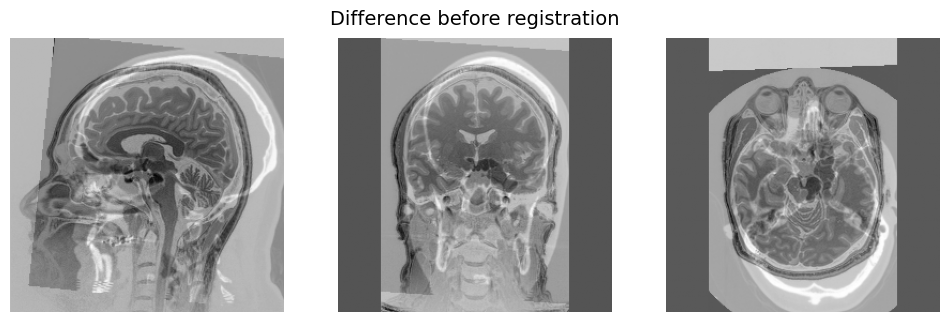

In [7]:
# Difference before registration.
t1 = sf.load_volume('t1.nii.gz')
ct = sf.load_volume('ct.nii.gz').resample_like(t1)
before = normalize(ct) - normalize(t1)

show(ct, title='CT scan')
show(t1, title='T1-weighted MRI')
show(before, title='Difference before registration')

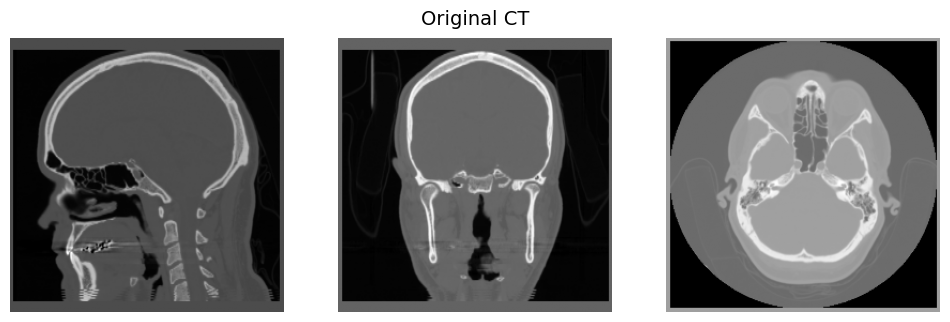

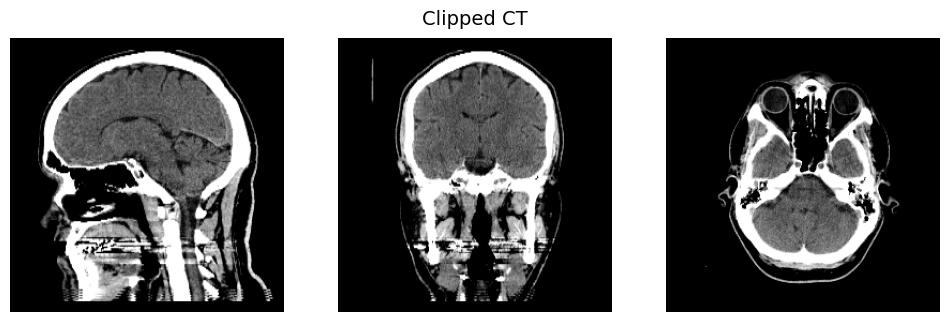

In [8]:
# CT clipping. Limit intensity scale to 0-80 in Hounsfield units (HU) to bring
# out soft-tissue contrast across the brain. SynthMorph also requires most of
# the brain to be within a 256-mm cube centered on the origin of physical space.
ct = sf.load_volume('ct.nii.gz')
clipped = ct.clip(0, 80)
clipped.save('clipped.nii.gz')

show(ct, title='Original CT')
show(clipped, title='Clipped CT')

In [9]:
# Brain-specific registration.
!./mri_synthmorph -m affine -t trans.lta clipped.nii.gz t1.nii.gz

E0000 00:00:1750868207.357696    1974 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750868207.364724    1974 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
#@# mri_synthmorph: affine, threads: None, VmPeak: 8988776
Thank you for choosing SynthMorph. Please cite us!

SynthMorph: learning contrast-invariant registration without acquired images
Hoffmann M, Billot B, Greve DN, Iglesias JE, Fischl B, Dalca AV
IEEE Transactions on Medical Imaging, 41 (3), 543-558, 2022
https://doi.org/10.1109/TMI.2021.3116879

Anatomy-specific acquisition-agnostic affine registration learned from
fictitious images
Hoffmann M, Hoopes A, Fischl B*, Dalca AV* (*equal contribution)
SPIE Medical Imaging: Image Processing, 12464, 1246402, 2023
https://doi.org/10.1117/12.2653251
https://synthmorph.io/#papers (PDF)

Anatom

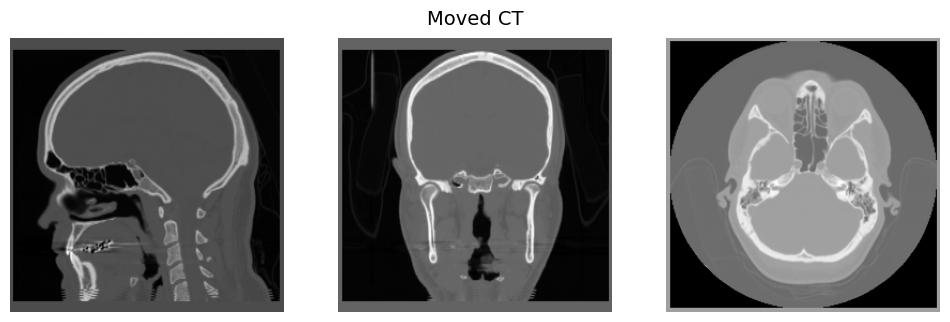

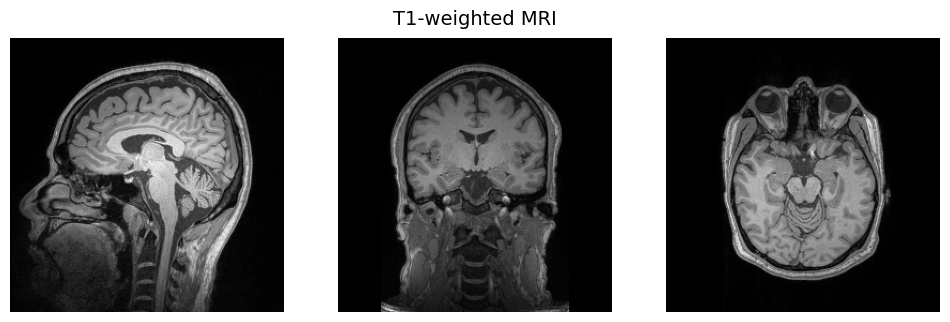

In [10]:
# Moved CT scan.
trans = sf.load_affine('trans.lta')
moved = sf.load_volume('ct.nii.gz').transform(trans)

show(ct, title='Moved CT')
show(t1, title='T1-weighted MRI')

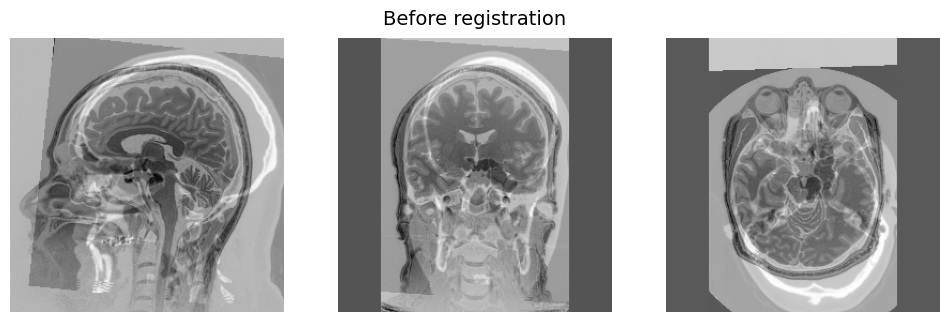

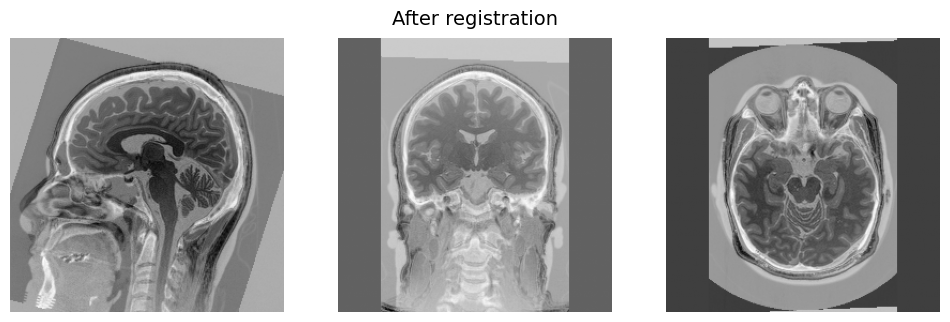

In [11]:
# Difference after registration.
after = normalize(moved) - normalize(t1)
show(before, title='Before registration')
show(after, title='After registration')

In [12]:
# Log package versions.
!pip freeze

absl-py==1.4.0
accelerate==1.7.0
aiofiles==24.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.11.15
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.8
ale-py==0.11.1
altair==5.5.0
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.9.0
argon2-cffi==25.1.0
argon2-cffi-bindings==21.2.0
array_record==0.7.2
arviz==0.21.0
astropy==7.1.0
astropy-iers-data==0.2025.6.16.0.38.47
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.8.0
babel==2.17.0
backcall==0.2.0
backports.tarfile==1.2.0
beautifulsoup4==4.13.4
betterproto==2.0.0b6
bigframes==2.7.0
bigquery-magics==0.9.0
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blobfile==3.0.0
blosc2==3.4.0
bokeh==3.7.3
Bottleneck==1.4.2
bqplot==0.12.45
branca==0.8.1
build==1.2.2.post1
CacheControl==0.14.3
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.6.15
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.2
chex==0.1.89
clarabel==0.11.1
click==8.2.1
cloudpathlib==0.21.1
cloudpickle==3.1.1
cmake==3.31.6
cmdstanp